In [2]:
import numpy as np
import pandas as pd
import importlib
import data_loader
import gibbs_sampler
importlib.reload(data_loader)
importlib.reload(gibbs_sampler)
from data_loader import CountryDataLoader
from gibbs_sampler import HierarchicalGibbsSampler
from scipy.sparse import block_diag as sparse_block_diag
import os

In [1]:
file_path = r'D:\Bachelor Data\Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]



loader.load_data(split_date="19321231")  # or 
pre_data = loader.pretrain_dict
train_data = loader.train_dict
X_dict_pre = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.pretrain_dict.items()
}

Y_dict_pre = {
    c: df["y"].to_numpy()
    for c, df in loader.pretrain_dict.items()
}

X_pre = np.vstack([X_dict_pre[c] for c in X_dict_pre])
Y_pre = np.concatenate([Y_dict_pre[c] for c in Y_dict_pre])
Z_pre = sparse_block_diag([X_dict_pre[c] for c in X_dict_pre]).tocsr()


# --- Train data ---
X_dict = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.train_dict.items()
}

Y_dict = {
    c: df["y"].to_numpy()
    for c, df in loader.train_dict.items()
}

X = np.vstack([X_dict[c] for c in X_dict])
Y = np.concatenate([Y_dict[c] for c in Y_dict])
Z = sparse_block_diag([X_dict[c] for c in X_dict]).tocsr()



NameError: name 'CountryDataLoader' is not defined

In [5]:
pre_data["usa"]["eom"].min()

Timestamp('1925-12-31 00:00:00')

In [6]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1e-6, fit_intercept=False)  
ridge.fit(X_pre, Y_pre)

theta_g_ridge = ridge.coef_
residuals = Y_pre - X_pre @ theta_g_ridge


In [7]:
theta_g_ridge

array([-1.26590746e-02, -9.64475924e-03, -4.67629968e-04, -3.01443941e-03,
       -7.29223611e-03, -2.05713226e-02, -9.11924499e-03, -1.38399258e-03,
       -9.32048054e-04, -9.16511888e+00,  2.66479453e-04, -2.18436415e-02,
       -2.72764541e-03, -3.42868749e-02,  1.65783235e-03, -7.93142188e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [ ]:

tau_theta_g_sq = np.var(theta_g_ridge) + 1e-1

resid_var = np.var(residuals)
alpha_sigma = 0.1
beta_sigma = resid_var / alpha_sigma

# Λ_c ~ Gamma(α, β) prior: set α * β = τ²
alpha_lambda = 0.2
beta_lambda = tau_theta_g_sq / alpha_lambda

# Wishart prior: mean(diag(Sigma)) = τ²
Sigma = tau_theta_g_sq * np.eye(X_pre.shape[1])
nu = X_pre.shape[1] + 2


n_iter = 10000
burn_in = 1000


In [13]:
sampler = HierarchicalGibbsSampler(
    X_dict=X_dict,
    Y_dict=Y_dict,
    X=X,
    Y=Y,
    Z=Z,
    n_iter=n_iter,
    burn_in=burn_in,
    tau_theta_g_sq=tau_theta_g_sq,
    alpha_sigma=alpha_sigma,
    beta_sigma=beta_sigma,
    hyper_type="gamma",  # or "gamma"
    alpha_lambda=alpha_lambda,
    beta_lambda=beta_lambda,
    Sigma=Sigma,
    nu=nu
)

sampler.run()

  5%|▌         | 515/10000 [23:26<7:11:47,  2.73s/it]


LinAlgError: Singular matrix

In [34]:
df = pd.read_parquet("theta_l_samples.parquet")
print(df.shape)
print([col for col in df.columns if col.startswith("usa_")])


(10000, 3774)
['usa_0', 'usa_1', 'usa_2', 'usa_3', 'usa_4', 'usa_5', 'usa_6', 'usa_7', 'usa_8', 'usa_9', 'usa_10', 'usa_11', 'usa_12', 'usa_13', 'usa_14', 'usa_15', 'usa_16', 'usa_17', 'usa_18', 'usa_19', 'usa_20', 'usa_21', 'usa_22', 'usa_23', 'usa_24', 'usa_25', 'usa_26', 'usa_27', 'usa_28', 'usa_29', 'usa_30', 'usa_31', 'usa_32', 'usa_33', 'usa_34', 'usa_35', 'usa_36', 'usa_37', 'usa_38', 'usa_39', 'usa_40', 'usa_41', 'usa_42', 'usa_43', 'usa_44', 'usa_45', 'usa_46', 'usa_47', 'usa_48', 'usa_49', 'usa_50', 'usa_51', 'usa_52', 'usa_53', 'usa_54', 'usa_55', 'usa_56', 'usa_57', 'usa_58', 'usa_59', 'usa_60', 'usa_61', 'usa_62', 'usa_63', 'usa_64', 'usa_65', 'usa_66', 'usa_67', 'usa_68', 'usa_69', 'usa_70', 'usa_71', 'usa_72', 'usa_73', 'usa_74', 'usa_75', 'usa_76', 'usa_77', 'usa_78', 'usa_79', 'usa_80', 'usa_81', 'usa_82', 'usa_83', 'usa_84', 'usa_85', 'usa_86', 'usa_87', 'usa_88', 'usa_89', 'usa_90', 'usa_91', 'usa_92', 'usa_93', 'usa_94', 'usa_95', 'usa_96', 'usa_97', 'usa_98', 'usa_

In [35]:
import importlib
import gibbs_sampler
importlib.reload(gibbs_sampler)
from gibbs_sampler import PosteriorAnalyzer

post_analyzer = PosteriorAnalyzer(
    theta_g_path="theta_g_samples.parquet",
    theta_l_path="theta_l_samples.parquet",
    gc_path="Gc_trace.parquet",
    burn_in=1000
)

theta_g_samples = post_analyzer.get_theta_g_samples()
theta_l_samples_usa = post_analyzer.get_theta_l_samples("usa")

In [36]:
theta_l_samples_usa

array([[-7.73303049e-06, -1.84788313e-06,  9.00118809e-06, ...,
         8.04027928e-06,  1.10239408e-05,  7.80407403e-07],
       [-1.21187573e-06,  2.24770365e-06, -5.25257228e-06, ...,
         2.39077886e-06, -1.75598924e-06,  5.44161995e-06],
       [-5.57562890e-06, -3.41220908e-06,  9.89232905e-06, ...,
         6.24108447e-06, -1.44422336e-05, -1.94280171e-05],
       ...,
       [-1.02096405e-05, -1.64153899e-05, -2.09932172e-05, ...,
         7.65019342e-06, -6.22264474e-05, -8.96660467e-06],
       [-9.94777719e-06,  5.97971597e-06,  3.34538230e-06, ...,
         5.75242379e-06,  2.01273867e-05,  3.67866197e-06],
       [ 8.44293601e-06,  1.13505185e-08, -7.46311682e-06, ...,
        -3.31667047e-06, -1.85282550e-07, -6.90630070e-06]],
      shape=(9000, 111))

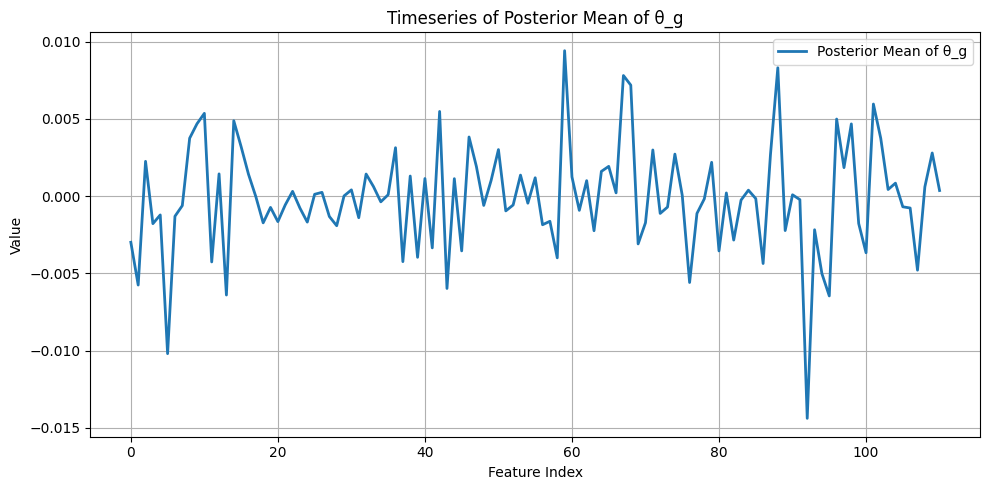

In [37]:
import matplotlib.pyplot as plt

post_analyzer.plot_timeseries("theta_g")


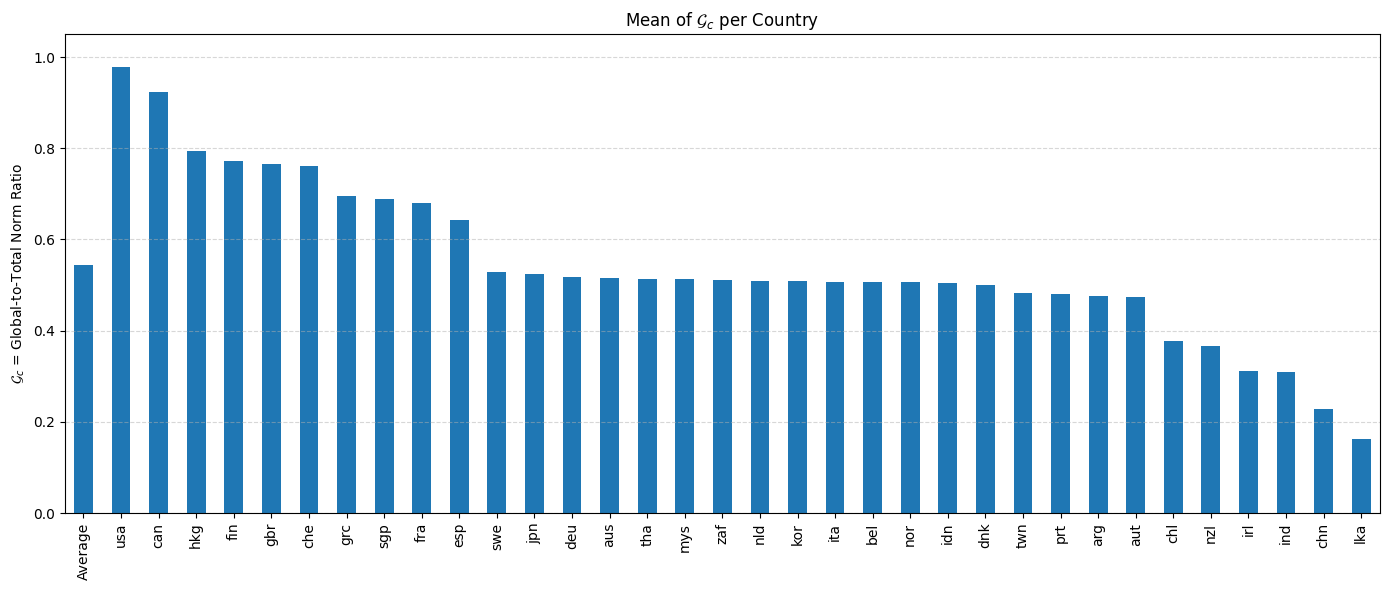

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get Gc means
Gc_mean = post_analyzer.get_Gc_posterior_mean()
Gc_mean["Average"] = np.mean([v for k, v in Gc_mean.items() if k != "Average"])

# Reorder: put 'Average' first, then the rest sorted descending
sorted_keys = ["Average"] + sorted([k for k in Gc_mean if k != "Average"], key=lambda x: Gc_mean[x], reverse=True)
Gc_mean_ordered = pd.Series({k: Gc_mean[k] for k in sorted_keys})

# Plot
Gc_mean_ordered.plot(kind="bar", figsize=(14, 6))
plt.title("Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("$\\mathcal{G}_c$ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




In [41]:
file_path = 'D:/Bachelor Data/Test'

loader_predict = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="test"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader_predict.load_data(split_date=None)

X_test = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader_predict.data_dict.items()
}

Y_test = {
    c: df["y"].to_numpy()
    for c, df in loader_predict.data_dict.items()
}


In [43]:
from sklearn.metrics import r2_score
import numpy as np

theta_g = post_analyzer.get_theta_g_mean()
theta_l = post_analyzer.get_theta_l_mean()

y_true_all = []
y_pred_all = []

for c in X_test:
    X_c = X_test[c]
    y_c = Y_test[c]

    if c not in theta_l:
        continue  # skip countries not in training set

    theta_total = theta_g + theta_l[c]
    y_pred = X_c @ theta_total

    y_true_all.append(y_c)
    y_pred_all.append(y_pred)

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)

print("$R^2" ,r2_score(y_true,y_pred)*100,"%")

$R^2 0.21104897912187504 %


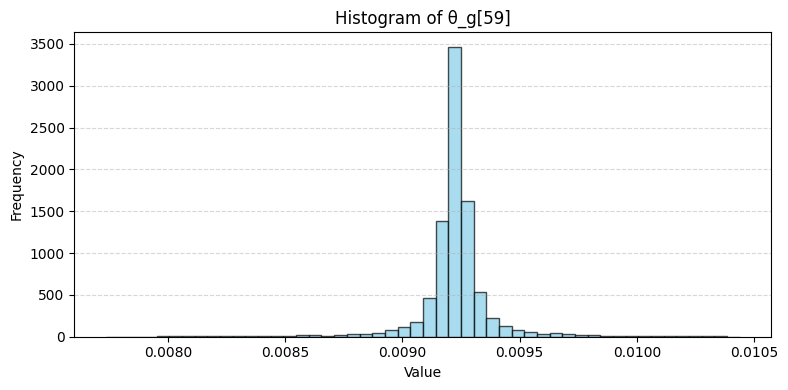

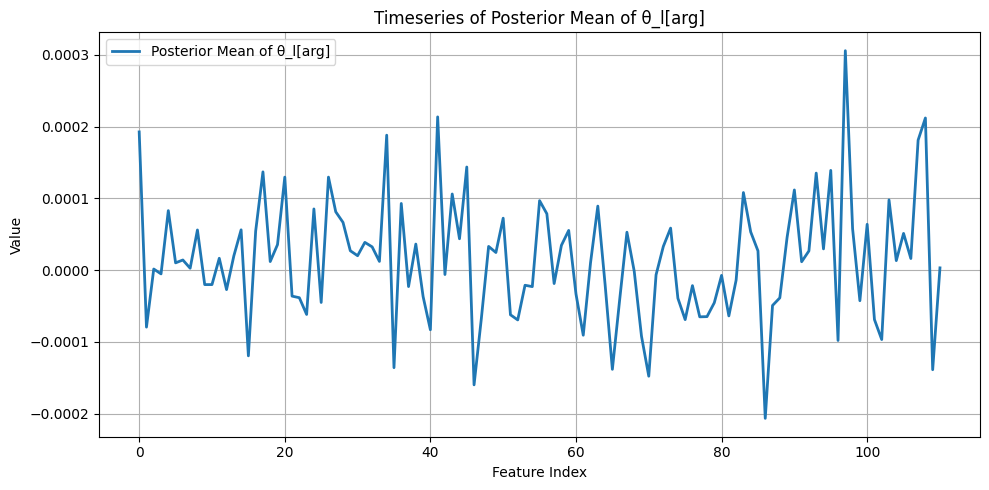

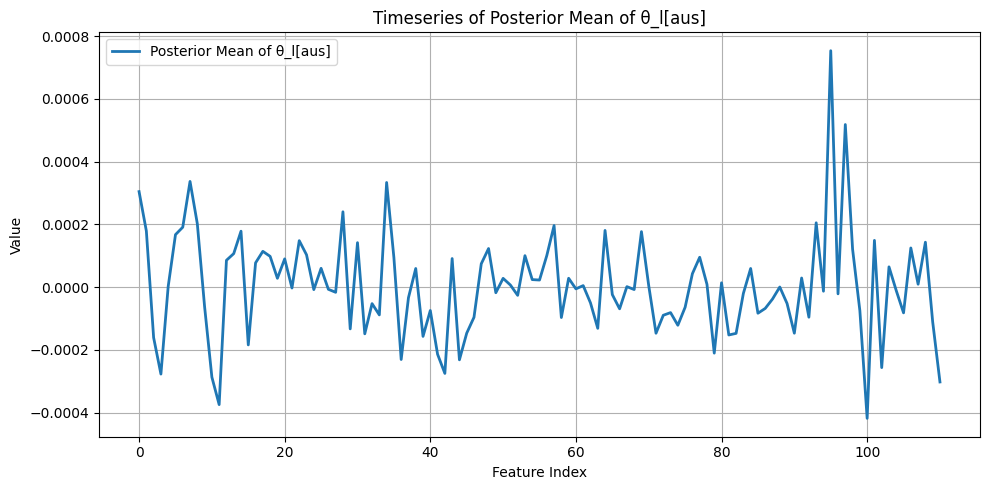

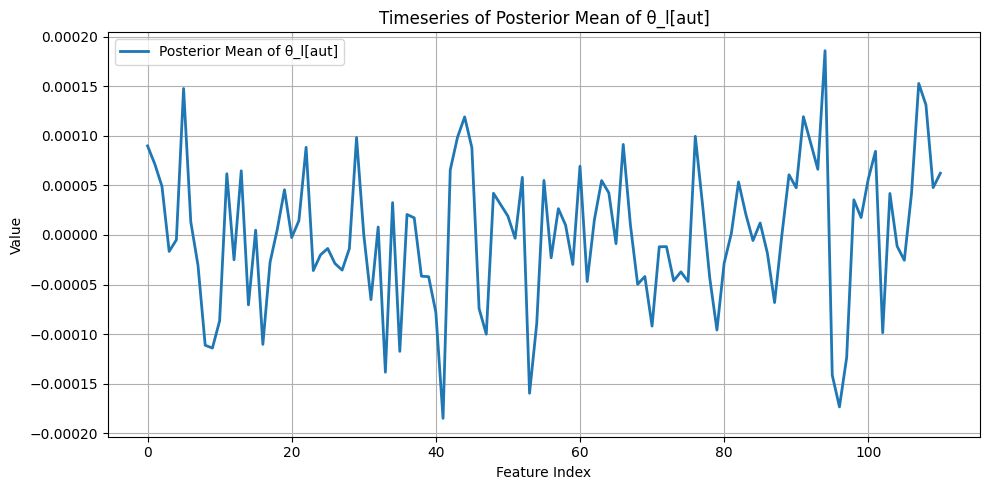

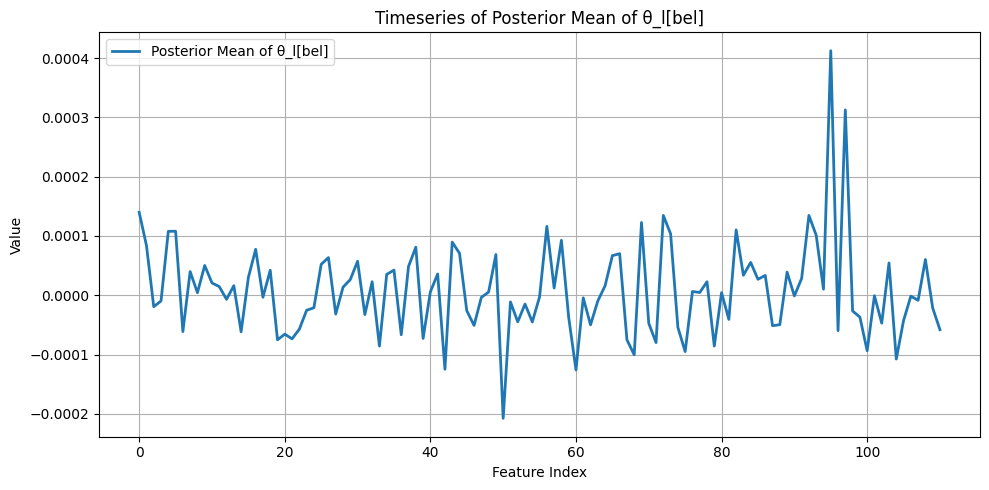

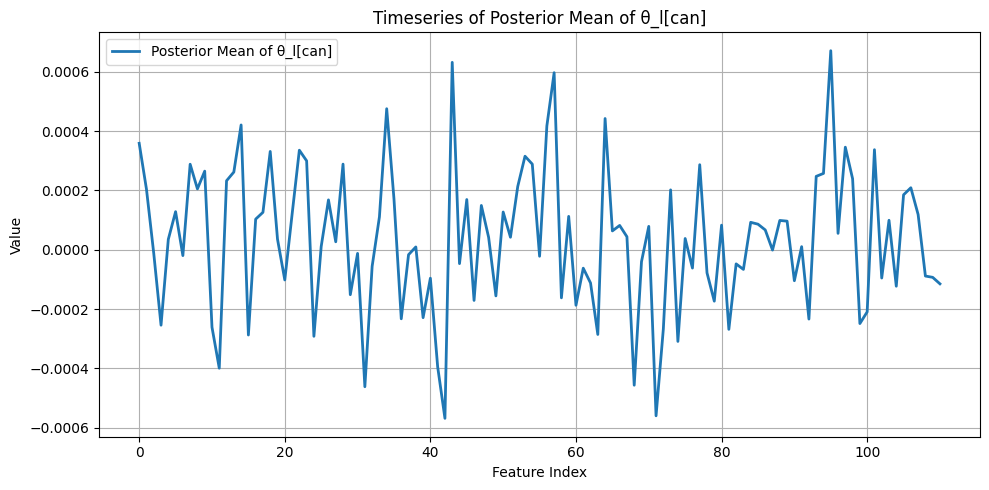

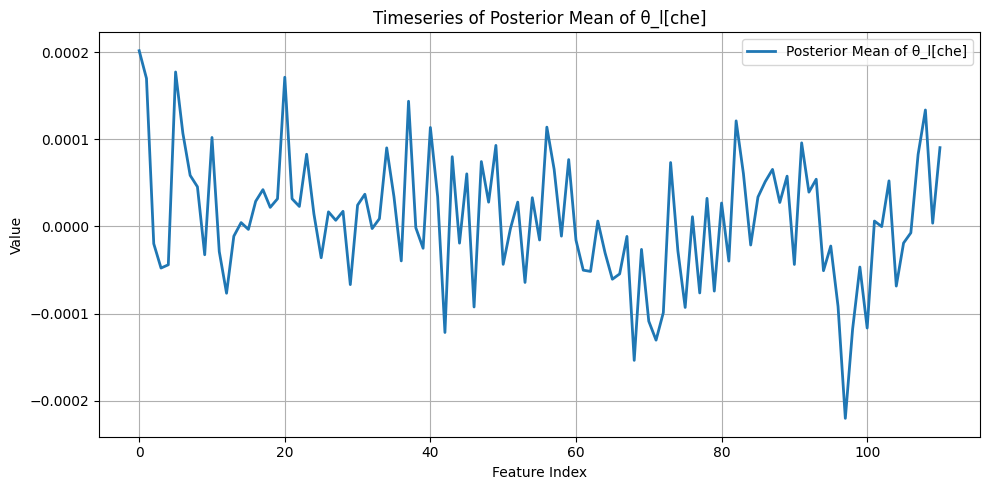

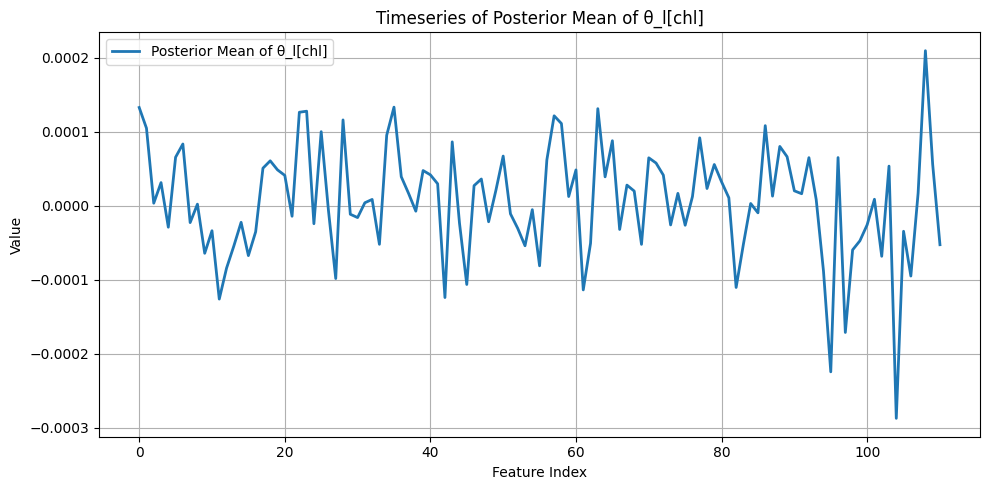

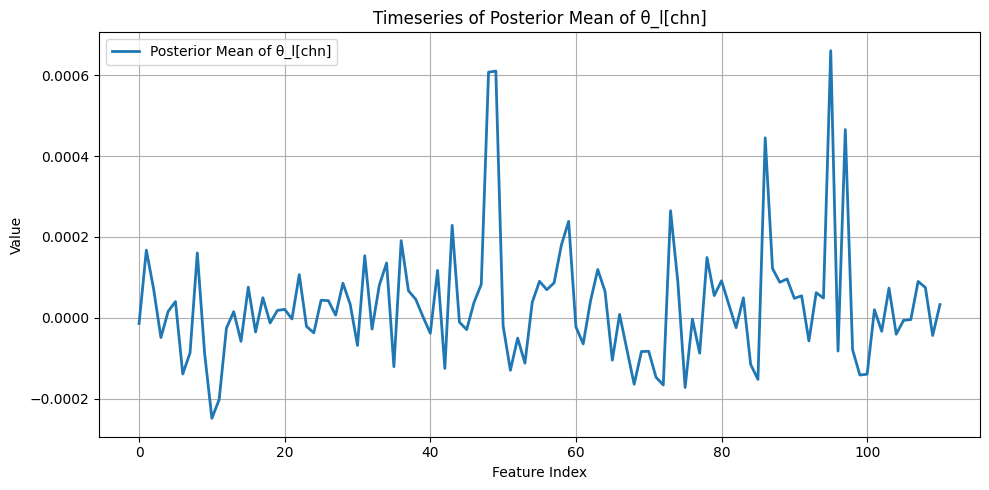

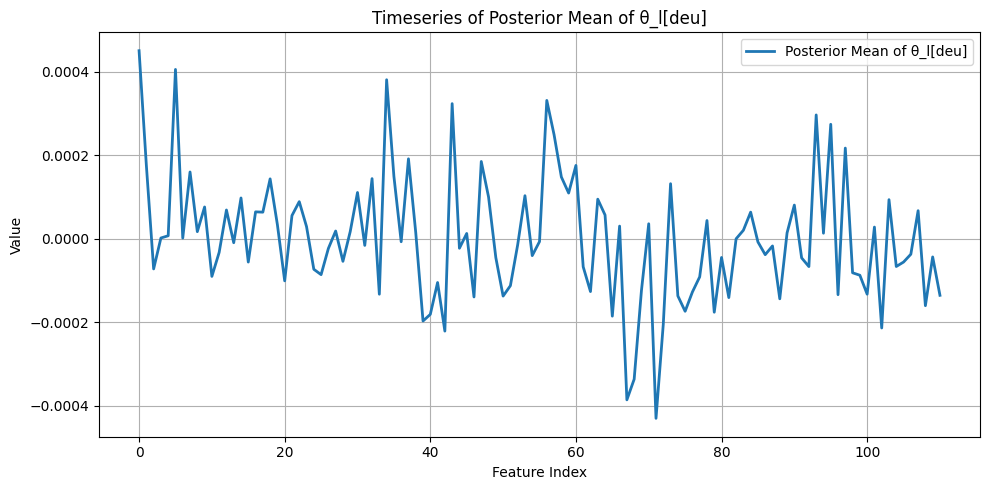

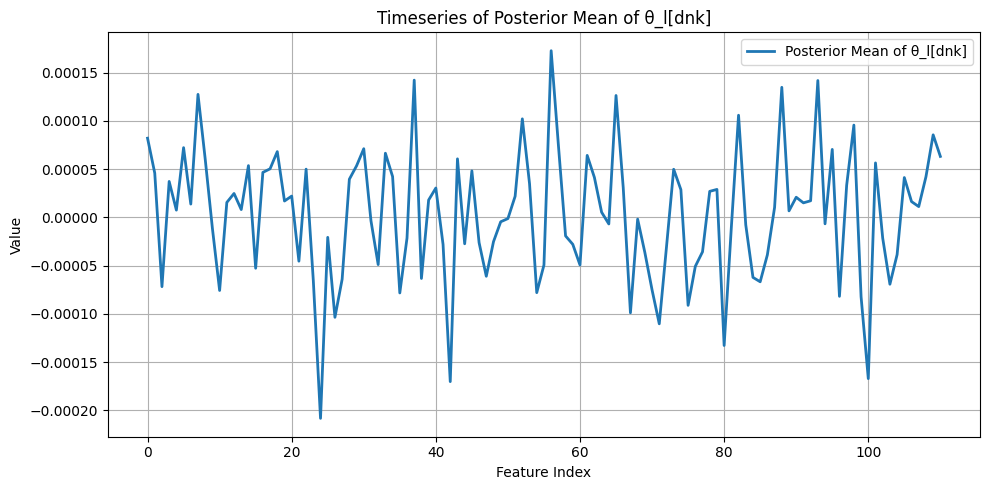

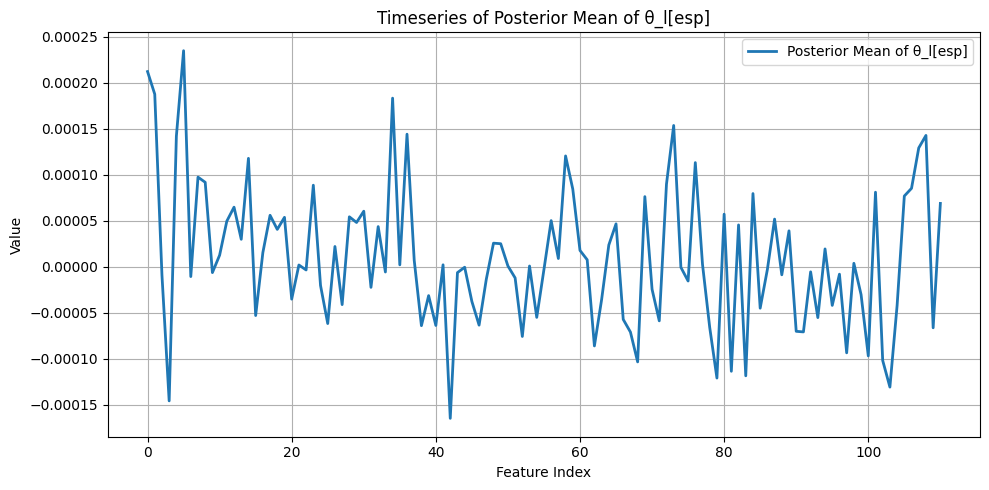

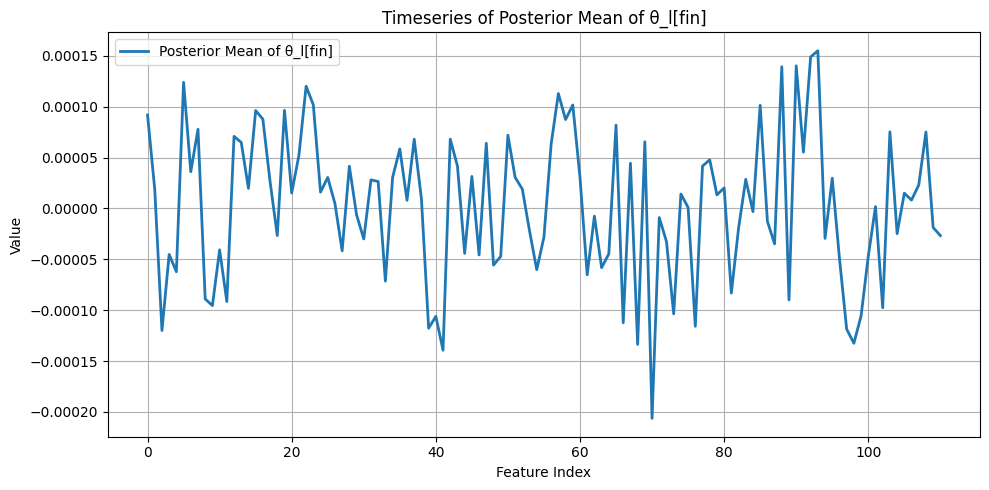

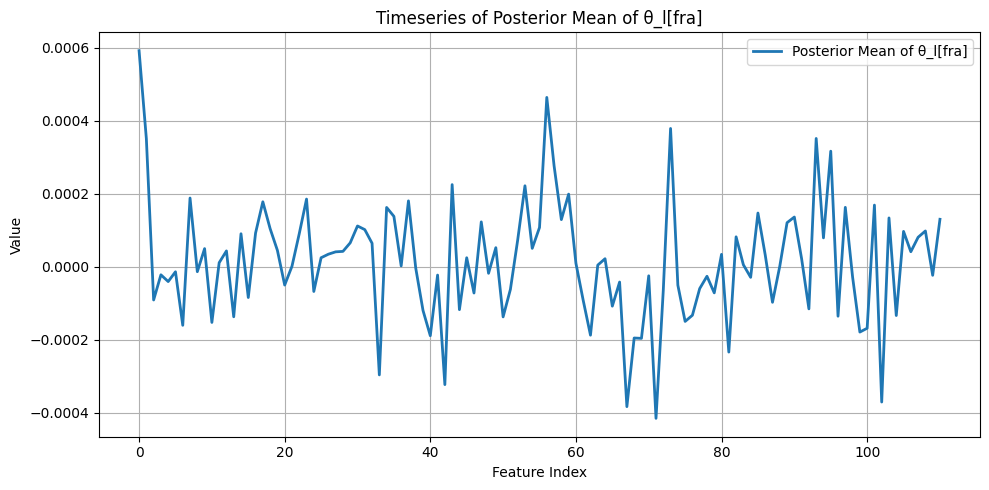

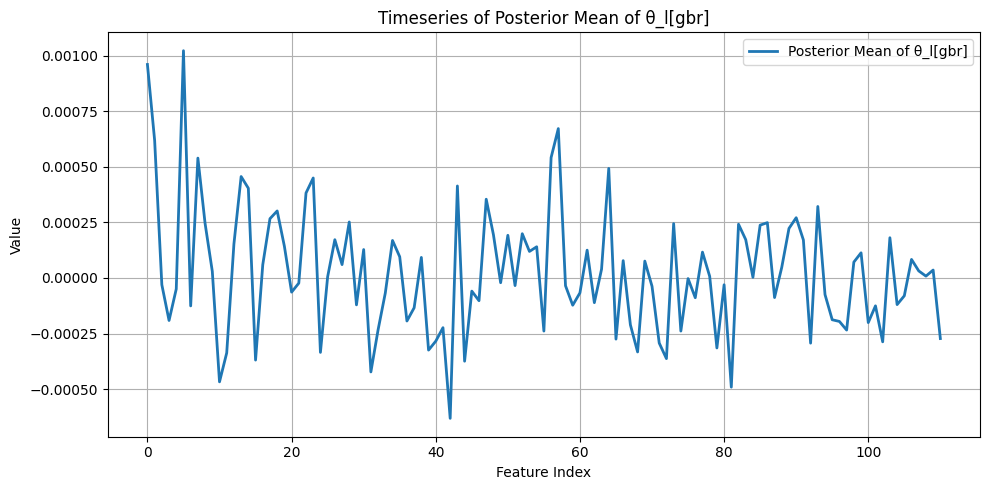

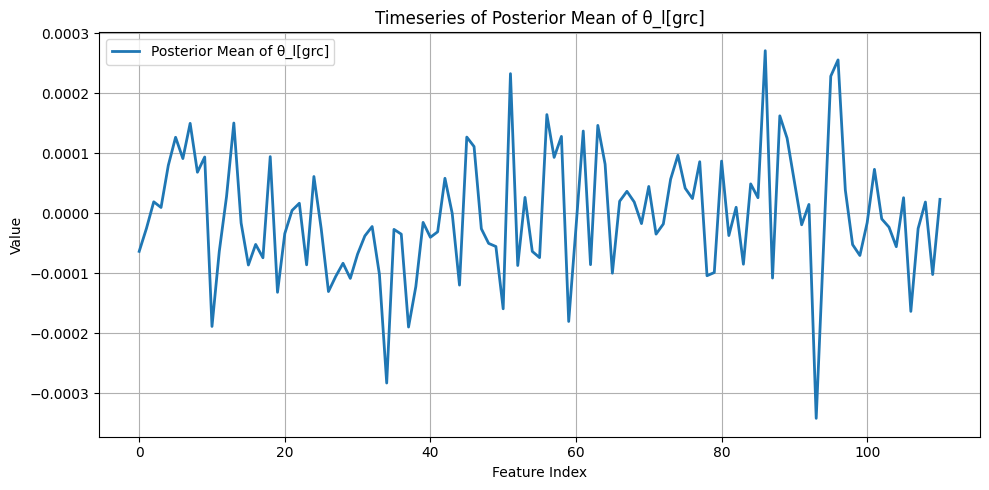

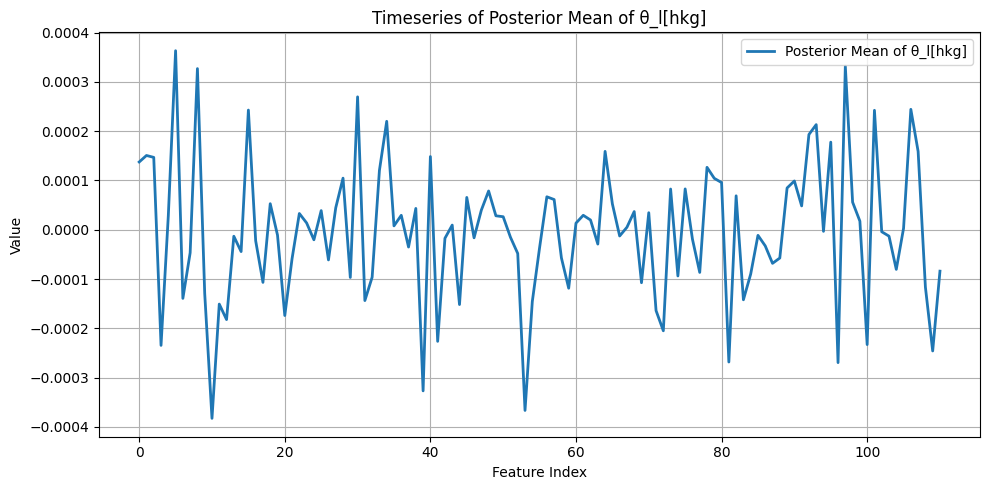

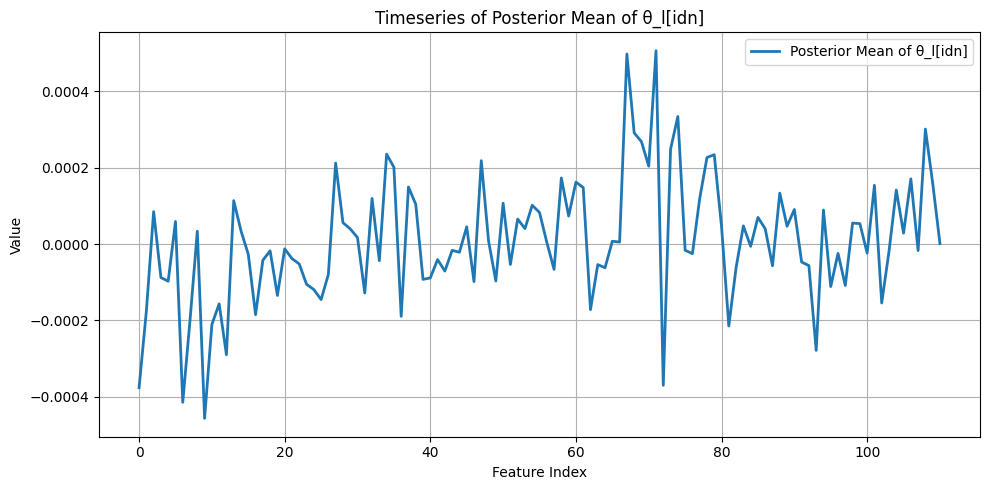

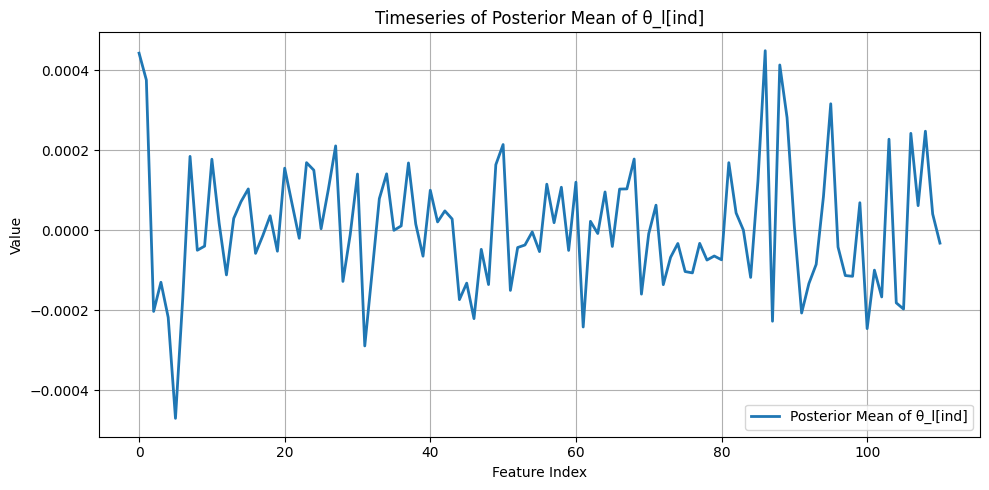

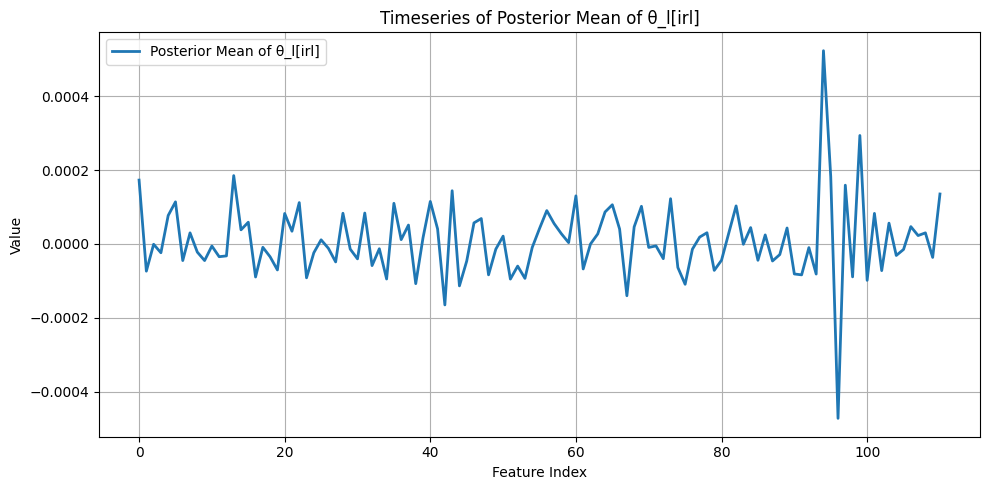

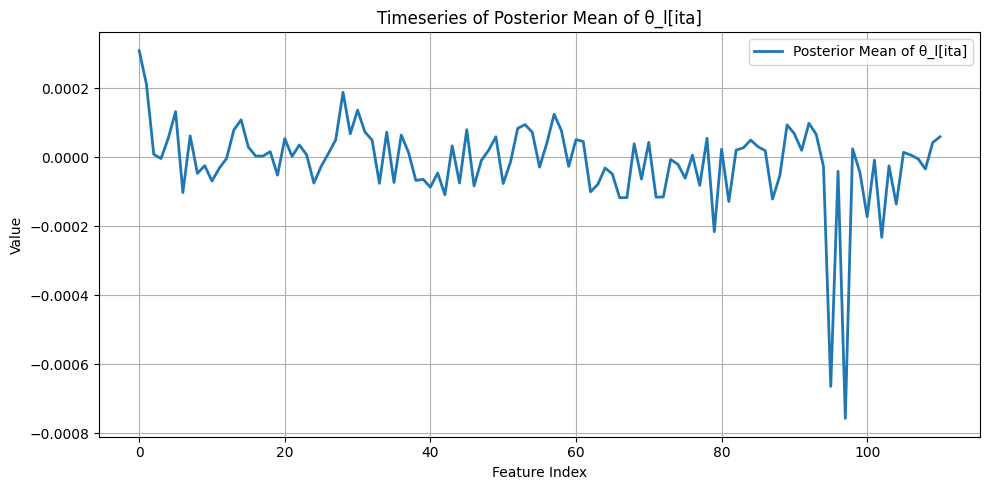

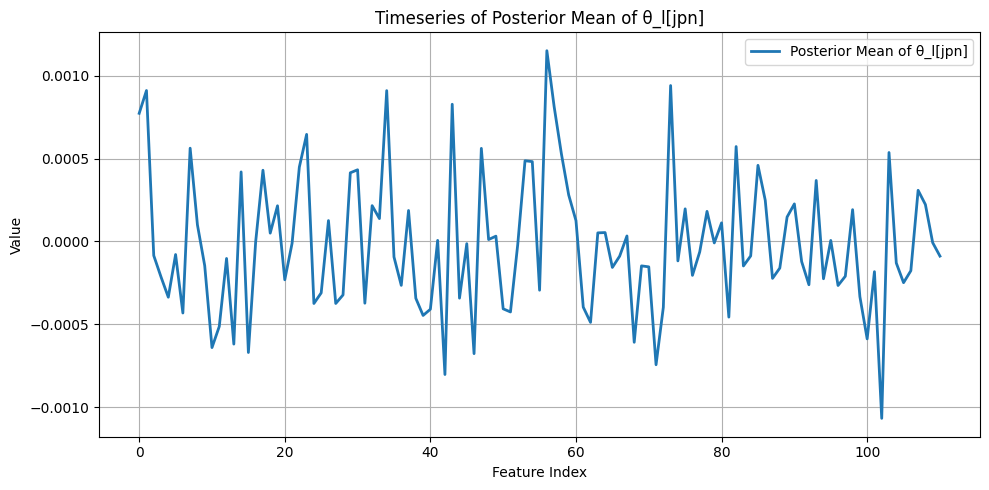

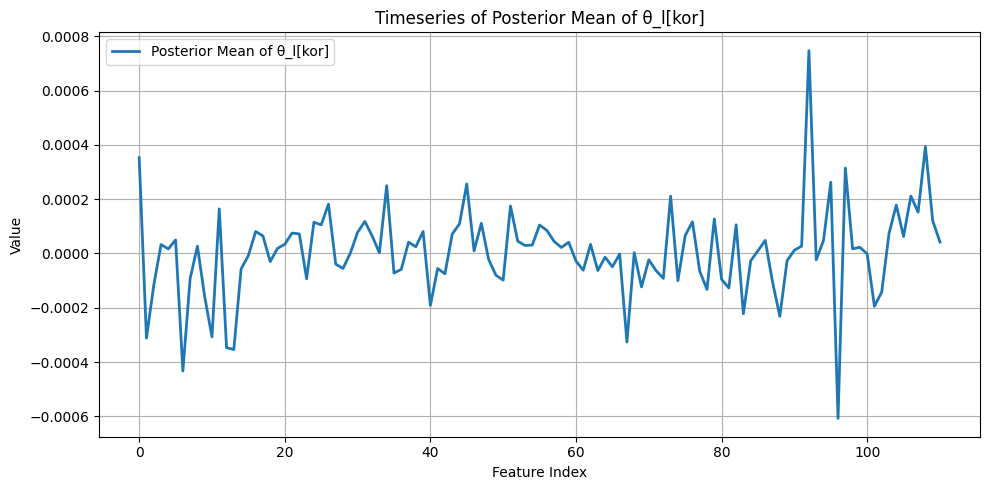

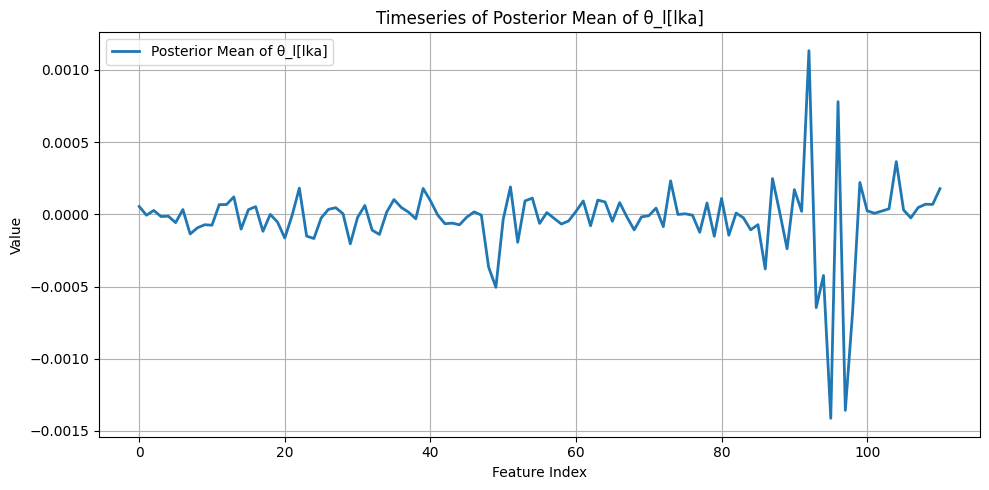

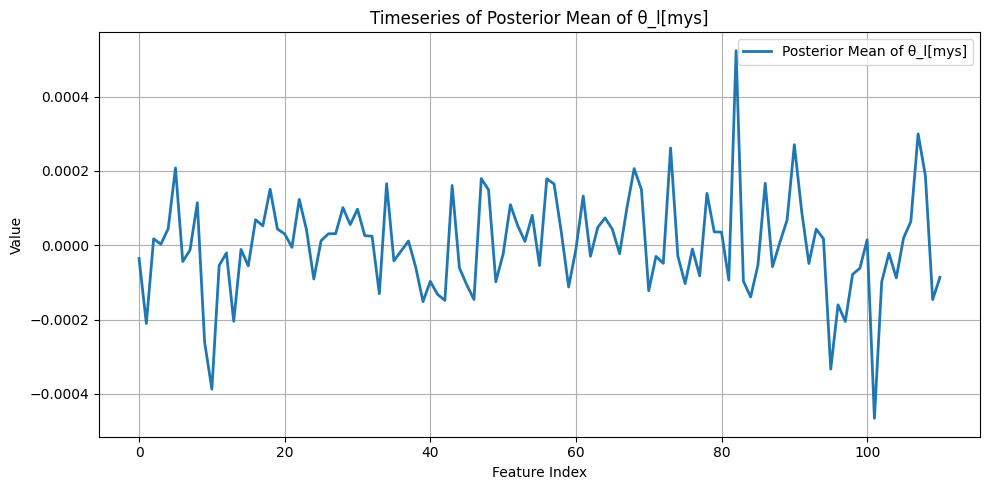

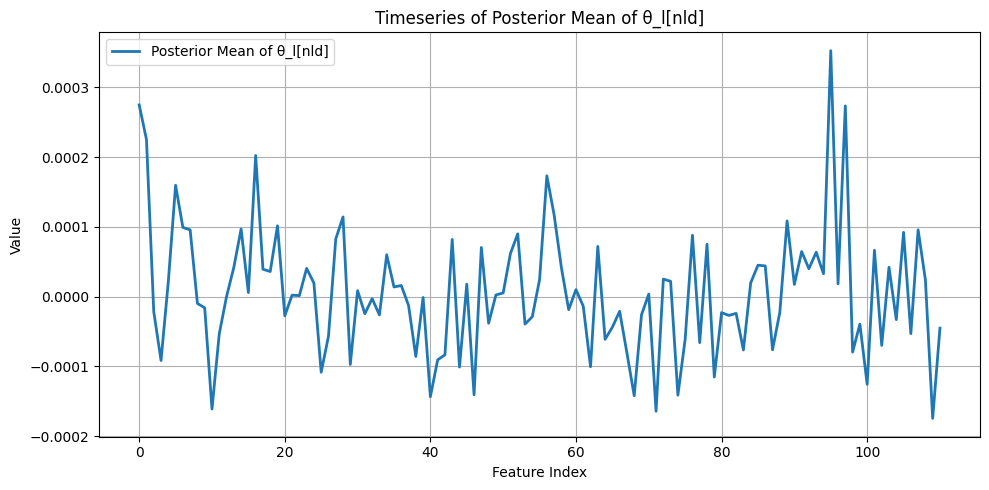

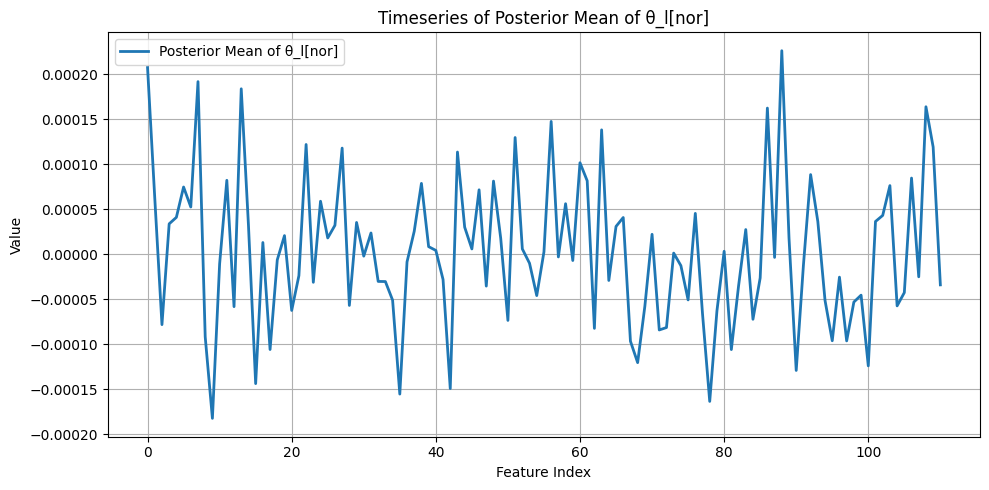

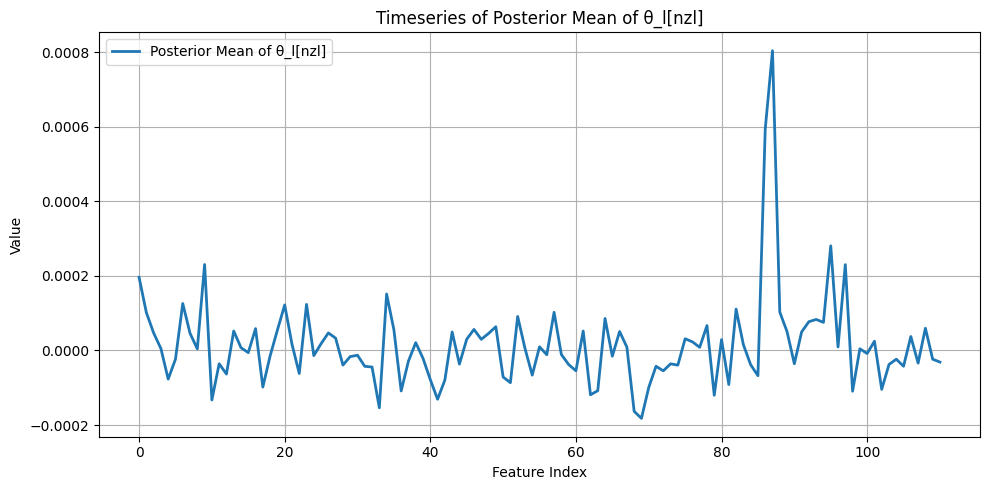

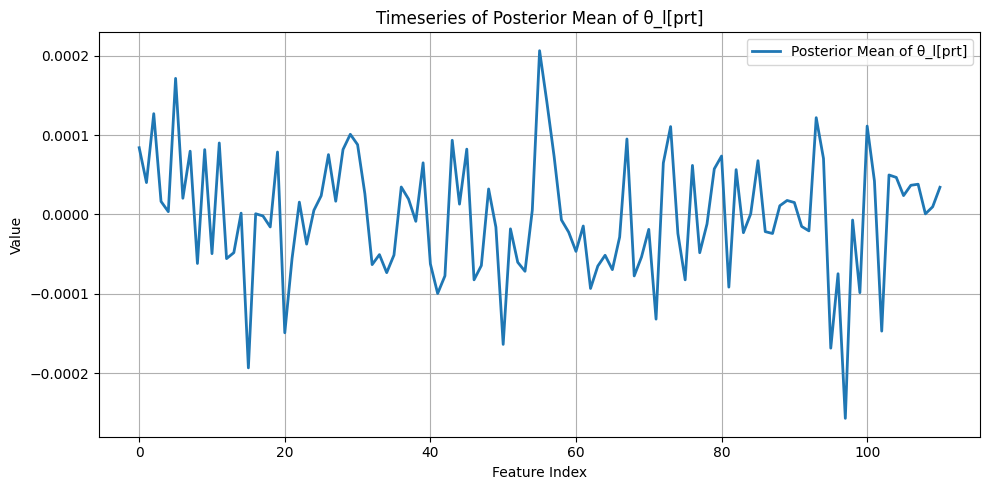

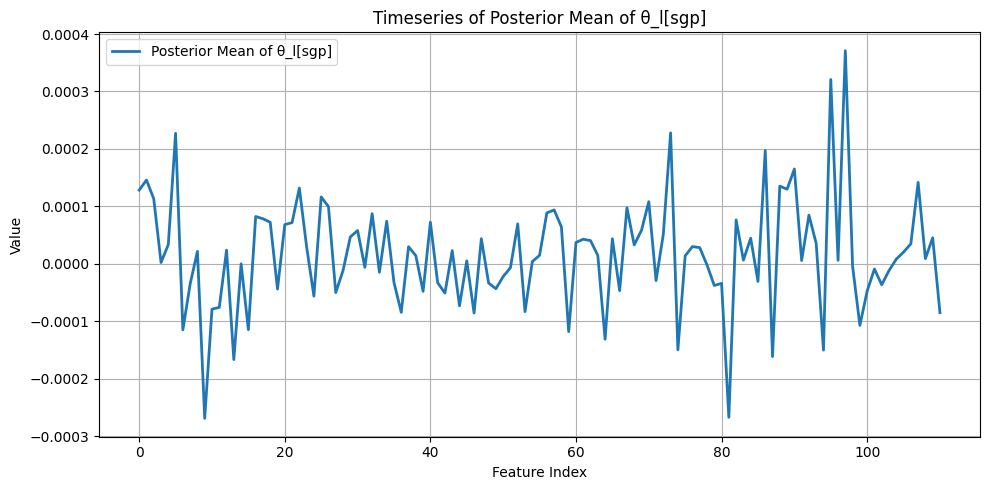

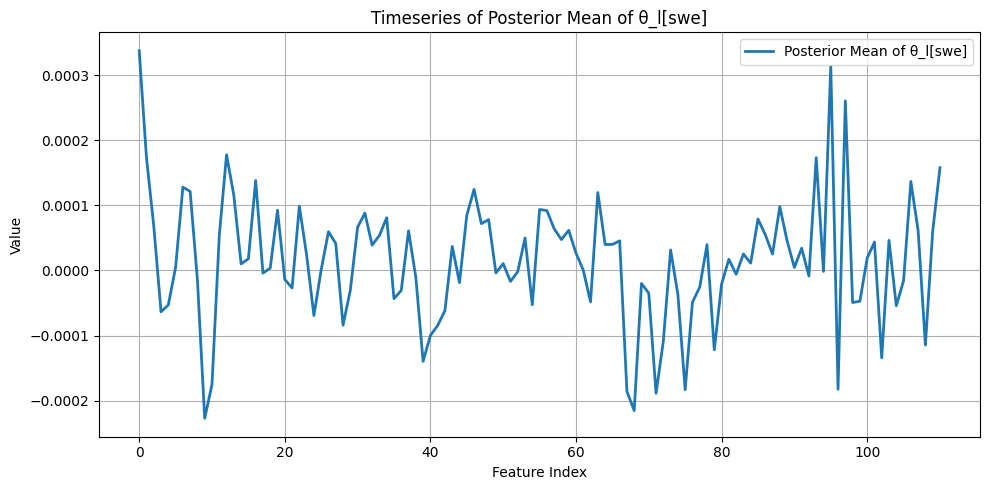

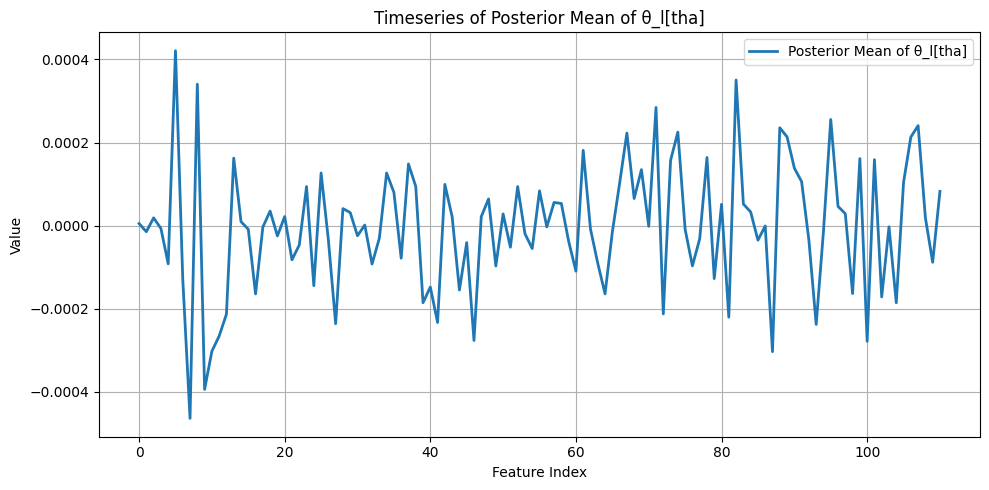

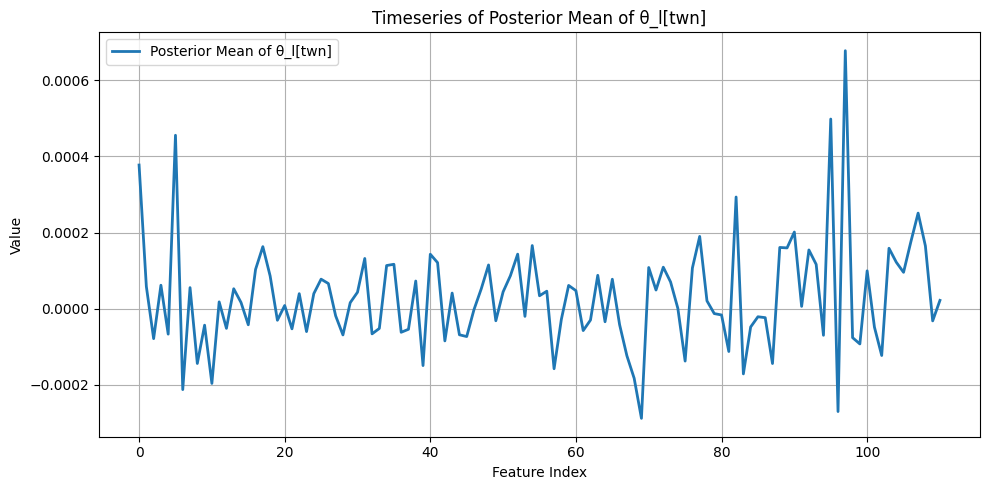

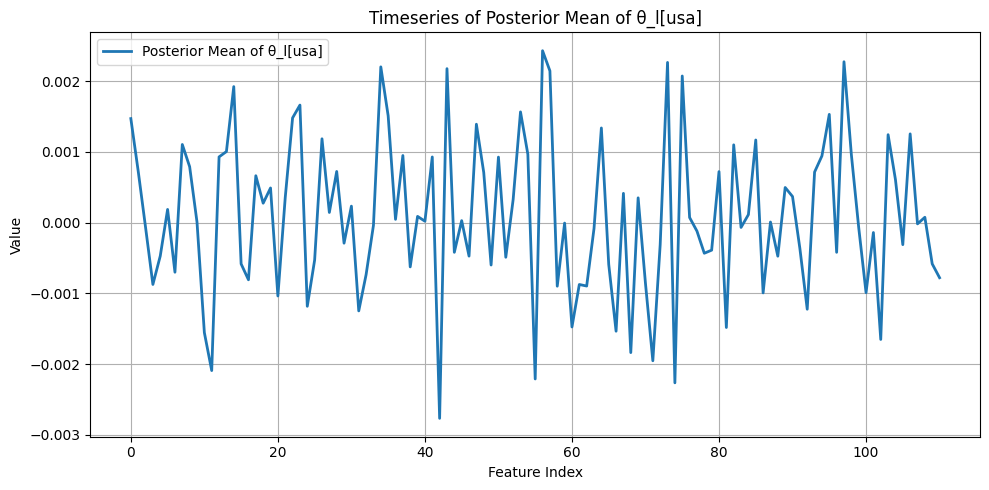

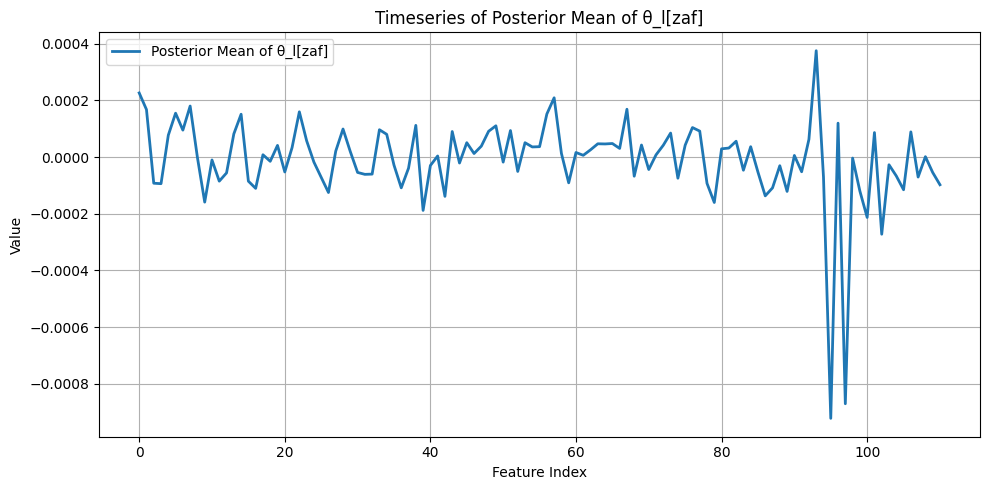

In [45]:
post_analyzer.plot_histogram("theta_g",59)

for c in X_test:
    post_analyzer.plot_timeseries("theta_l",c)